
# PFM: Building Machine Learning Models

## **1. Importar librerías y datos**

In [164]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
# Librerias pickle y csv
import pickle
import csv

#importing models
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR

from sklearn import preprocessing, model_selection, metrics


In [165]:
#Cargamos los datasets y las definiciones de las variables para tenerlas a mano

def load_obj(name ):
       with open('obj/' + name + '.pkl', 'rb') as f:
           return pickle.load(f)

df_REE=load_obj('df_Tenerife_Electricity_full_2019_clean+EDA');
dict_REE=load_obj('dict_descripcion_df_Electricity');
df_Meteo=load_obj('df_Tenerife_Meteo_28.14_-16.46_full_2019_clean+EDA');
dict_Meteo=load_obj('dict_descripcion_df_Meteo');

## **2. Combinar los datasets**

En este apartado se combinan los datasets de manera que tengamos un único conjunto de datos, facilitando así la manipulación de estos y la construcción de los modelos. Este paso es importante para evitar errores y confusiones más adelante.


In [166]:
#Eliminamos los atributos 'Month', 'Weekday' y 'Season' de uno de los datasets para evitar que queden duplicados al hacer la combinación de los dos conjuntos de datos.

df_REE=df_REE.drop(['Month','Weekday','Season'], axis=1)
df_REE.head()

,Generacion_no_renovable_MW,Generacion_renovable_MW,Demanda_real_MW,Generacion_FV_MW,Generacion_TV_MW,Generacion_CC_MW,Generacion_EO_MW,Generacion_TG_MW,Generacion_MD_MW,Demanda_programada_MW,Precio_generacion_€MWh,Aportacion_renovable_%
time_series,,,,,,,,,,,,
2019-01-01 00:00:00,347.6,0.0,347.6,0.0,173.2,159.0,0.0,0.0,15.4,343.4,156.18,0.000000
2019-01-01 00:10:00,345.0,0.0,345.0,0.0,176.2,152.8,0.0,0.0,16.0,343.4,156.18,0.000000
2019-01-01 00:20:00,346.9,0.1,347.0,0.0,174.9,155.9,0.1,0.0,16.1,343.4,156.18,0.028818
2019-01-01 00:30:00,344.5,0.2,344.7,0.0,173.8,155.4,0.2,0.0,15.3,343.4,156.18,0.058021
2019-01-01 00:40:00,342.9,0.1,343.0,0.0,175.8,151.6,0.1,0.0,15.5,343.4,156.18,0.029155


In [167]:
#Unimos los datasets  mediante .join()
#Esta función combina los datasets de acuerdo al índice del dataset principal (left)
df_ML=df_REE.join(df_Meteo)
df_ML.head()

,Generacion_no_renovable_MW,Generacion_renovable_MW,Demanda_real_MW,Generacion_FV_MW,Generacion_TV_MW,Generacion_CC_MW,Generacion_EO_MW,Generacion_TG_MW,Generacion_MD_MW,Demanda_programada_MW,...,Temp_Rocio_ºC,GHI_Wm2,TPW_Kgm2,RH_%,WD_10m_º,WS_10m_ms,Zenith_º,Month,Weekday,Season
2019-01-01 00:00:00,347.6,0.0,347.6,0.0,173.2,159.0,0.0,0.0,15.4,343.4,...,7.5,0.0,8.2,54.6,119.0,3.5,163.0,1,2,Invierno
2019-01-01 00:10:00,345.0,0.0,345.0,0.0,176.2,152.8,0.0,0.0,16.0,343.4,...,7.4,0.0,8.2,54.4,118.0,3.5,165.0,1,2,Invierno
2019-01-01 00:20:00,346.9,0.1,347.0,0.0,174.9,155.9,0.1,0.0,16.1,343.4,...,7.7,0.0,8.1,54.8,117.0,3.5,167.0,1,2,Invierno
2019-01-01 00:30:00,344.5,0.2,344.7,0.0,173.8,155.4,0.2,0.0,15.3,343.4,...,8.0,0.0,8.1,55.4,115.0,3.6,169.0,1,2,Invierno
2019-01-01 00:40:00,342.9,0.1,343.0,0.0,175.8,151.6,0.1,0.0,15.5,343.4,...,8.2,0.0,8.0,55.9,114.0,3.6,171.0,1,2,Invierno


In [168]:
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52522 entries, 2019-01-01 00:00:00 to 2019-12-31 23:50:00
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Generacion_no_renovable_MW  52522 non-null  float64
 1   Generacion_renovable_MW     52522 non-null  float64
 2   Demanda_real_MW             52522 non-null  float64
 3   Generacion_FV_MW            52522 non-null  float64
 4   Generacion_TV_MW            52522 non-null  float64
 5   Generacion_CC_MW            52522 non-null  float64
 6   Generacion_EO_MW            52522 non-null  float64
 7   Generacion_TG_MW            52522 non-null  float64
 8   Generacion_MD_MW            52522 non-null  float64
 9   Demanda_programada_MW       52522 non-null  float64
 10  Precio_generacion_€MWh      52522 non-null  float64
 11  Aportacion_renovable_%      52522 non-null  float64
 12  Temp_Aire_ºC                52522 non-null  float64
 

In [169]:
df_ML.describe()

,Generacion_no_renovable_MW,Generacion_renovable_MW,Demanda_real_MW,Generacion_FV_MW,Generacion_TV_MW,Generacion_CC_MW,Generacion_EO_MW,Generacion_TG_MW,Generacion_MD_MW,Demanda_programada_MW,...,Nubosidad_%,Temp_Rocio_ºC,GHI_Wm2,TPW_Kgm2,RH_%,WD_10m_º,WS_10m_ms,Zenith_º,Month,Weekday
count,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,...,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000,52522.000000
mean,330.727111,78.416148,409.143252,21.609013,123.647871,173.689606,56.807134,11.936868,21.452770,409.627204,...,6.591025,12.647803,243.694090,16.121736,69.674243,68.715414,5.917136,89.770192,6.524485,3.992536
std,82.004362,67.872114,79.170377,29.825503,45.359021,52.539022,53.238873,17.667290,13.804189,78.815017,...,14.328706,2.655771,322.729937,4.955958,12.977682,81.423938,2.538489,41.727244,3.448432,1.999139
min,91.000000,0.000000,179.600000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,262.900000,...,0.000000,-3.500000,0.000000,4.700000,21.100000,0.000000,0.000000,5.000000,1.000000,1.000000
25%,273.400000,16.500000,328.800000,0.000000,93.100000,143.700000,6.500000,0.000000,14.700000,330.500000,...,0.000000,11.500000,0.000000,12.900000,63.300000,30.000000,4.200000,54.000000,4.000000,2.000000
50%,324.600000,64.200000,431.200000,0.000000,122.800000,163.200000,41.000000,0.000000,18.800000,432.400000,...,0.000000,12.900000,5.000000,15.600000,72.300000,41.000000,6.100000,90.000000,7.000000,4.000000
75%,393.500000,127.400000,477.100000,43.600000,162.100000,202.300000,101.700000,20.700000,34.900000,478.200000,...,3.800000,14.300000,480.000000,18.400000,79.100000,57.000000,7.700000,125.000000,10.000000,6.000000
max,550.900000,265.600000,572.500000,99.800000,211.700000,396.000000,181.900000,206.500000,40.600000,570.900000,...,99.100000,18.900000,1090.000000,40.500000,95.600000,360.000000,14.300000,175.000000,12.000000,7.000000


Algunas preguntas que me vienen a la cabeza:

- ¿Eliminamos el atributo 'Aportacion_renovable_%'?
- ¿Puede ser interesante introducir una columna con la hora?
- ¿Separamos el dataset de info en real time del dataset de info day-ahead?
- ¿Hay que cambiar el formato de la columna 'Season'? ¿One Hot Encoding?
- Hay muchos atributos ¿Aplicamos featuring selection?
- Los atributos presentan diferentes unidades ¿Escalado de variables?
- Recordamos que las distribuciones de los atributos son peculiares ¿Normalización?
- ¿Analizar modelos con y sin entandarización?


## **3. Preparación de los datos**

En este apartado se tiene por objetivo definir el conjunto de datos que se va a utilizar para entrenar los algoritmos y para las diferentes aplicaciones de machine learning. Aquí se refleja la importancia del EDA, pues se toman decisiones de acuerdo a su análisis que tendrán repercusiones en los resultados de los modelos.

### **3.1 Variable Horaria**

En primer lugar nos centramos en introducir una nueva columna que ofrece información de la hora. Como se ha visto previamente en el EDA, el precio de generación de electricidad presenta una relación clara con la hora del día por lo que se debe incluír esta variable.

In [170]:
df_ML['Hour']=df_ML.index.hour
df_ML.head()

#Por el momento dejamos la columna 'Aportacion_renovable' 

,Generacion_no_renovable_MW,Generacion_renovable_MW,Demanda_real_MW,Generacion_FV_MW,Generacion_TV_MW,Generacion_CC_MW,Generacion_EO_MW,Generacion_TG_MW,Generacion_MD_MW,Demanda_programada_MW,...,GHI_Wm2,TPW_Kgm2,RH_%,WD_10m_º,WS_10m_ms,Zenith_º,Month,Weekday,Season,Hour
2019-01-01 00:00:00,347.6,0.0,347.6,0.0,173.2,159.0,0.0,0.0,15.4,343.4,...,0.0,8.2,54.6,119.0,3.5,163.0,1,2,Invierno,0
2019-01-01 00:10:00,345.0,0.0,345.0,0.0,176.2,152.8,0.0,0.0,16.0,343.4,...,0.0,8.2,54.4,118.0,3.5,165.0,1,2,Invierno,0
2019-01-01 00:20:00,346.9,0.1,347.0,0.0,174.9,155.9,0.1,0.0,16.1,343.4,...,0.0,8.1,54.8,117.0,3.5,167.0,1,2,Invierno,0
2019-01-01 00:30:00,344.5,0.2,344.7,0.0,173.8,155.4,0.2,0.0,15.3,343.4,...,0.0,8.1,55.4,115.0,3.6,169.0,1,2,Invierno,0
2019-01-01 00:40:00,342.9,0.1,343.0,0.0,175.8,151.6,0.1,0.0,15.5,343.4,...,0.0,8.0,55.9,114.0,3.6,171.0,1,2,Invierno,0


### **3.2 Transformación de datos categóricos**

A continuación utilizaremos el método One Hot Encoding para transformar las variables categóricas del atributo 'Season' en vectores binarios, este método facilita el aprendizaje de los modelos de machine learning y suele dar un resultado positivo.

#### Label Encoding

In [171]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df_ML['Season_i'] = labelencoder.fit_transform(df_ML['Season'])
df_ML.sample(10)

,Generacion_no_renovable_MW,Generacion_renovable_MW,Demanda_real_MW,Generacion_FV_MW,Generacion_TV_MW,Generacion_CC_MW,Generacion_EO_MW,Generacion_TG_MW,Generacion_MD_MW,Demanda_programada_MW,...,TPW_Kgm2,RH_%,WD_10m_º,WS_10m_ms,Zenith_º,Month,Weekday,Season,Hour,Season_i
2019-04-22 03:00:00,259.5,9.4,268.9,0.0,96.2,144.6,9.4,0.0,18.7,265.9,...,15.7,81.6,340.0,6.5,132.0,4,1,Primavera,3,2
2019-01-02 22:00:00,427.2,44.4,471.6,0.0,184.5,203.3,44.4,7.6,31.8,435.3,...,10.4,74.5,65.0,6.6,136.0,1,3,Invierno,22,0
2019-06-20 22:00:00,457.8,16.2,474.0,0.0,188.8,224.6,16.2,14.9,29.5,447.2,...,17.0,76.2,36.0,4.4,111.0,6,4,Invierno,22,0
2019-05-24 14:30:00,268.7,227.7,496.4,92.3,81.4,153.6,135.4,16.7,17.0,489.1,...,19.6,81.8,28.0,9.7,20.0,5,5,Primavera,14,2
2019-07-25 01:00:00,291.1,50.7,341.8,0.0,122.4,168.7,50.7,0.0,0.0,324.9,...,8.2,40.6,36.0,5.7,132.0,7,4,Verano,1,3
2019-05-29 03:50:00,281.6,1.2,282.8,0.0,99.9,164.5,1.2,0.0,17.2,282.3,...,17.0,88.0,14.0,6.8,117.0,5,3,Primavera,3,2
2019-04-16 01:20:00,291.7,6.8,298.5,0.0,110.6,146.8,6.8,0.0,34.3,293.8,...,15.1,87.4,51.0,5.1,142.0,4,2,Primavera,1,2
2019-01-23 11:10:00,338.7,152.6,491.3,64.5,173.9,146.9,88.1,0.0,17.9,486.0,...,12.1,62.0,49.0,7.5,58.0,1,3,Invierno,11,0
2019-11-14 03:00:00,167.8,120.9,288.7,0.0,93.0,74.8,120.9,0.0,0.0,287.5,...,11.0,79.1,22.0,7.5,150.0,11,4,Otoño,3,1
2019-05-13 07:30:00,386.6,1.0,387.6,0.1,177.3,183.8,0.9,8.0,17.5,390.1,...,16.8,89.6,18.0,5.6,77.0,5,1,Primavera,7,2


#### One Hot Encoding

In [172]:
# generate binary values using get_dummies
df_ML = pd.get_dummies(df_ML, columns=["Season"], prefix=None )
#dum_df['time_series'] = df_ML.index[:]
# merge with main df bridge_df on key values
#df_ML = df_ML.merge(dum_df, how='left')

df_ML=df_ML.drop(['Season_Invierno','Season_Otoño','Season_Primavera','Season_Verano'],axis=1)

df_ML.sample(10)

,Generacion_no_renovable_MW,Generacion_renovable_MW,Demanda_real_MW,Generacion_FV_MW,Generacion_TV_MW,Generacion_CC_MW,Generacion_EO_MW,Generacion_TG_MW,Generacion_MD_MW,Demanda_programada_MW,...,GHI_Wm2,TPW_Kgm2,RH_%,WD_10m_º,WS_10m_ms,Zenith_º,Month,Weekday,Hour,Season_i
2019-05-27 17:00:00,320.7,138.5,459.2,65.7,87.5,187.5,72.8,13.7,32.0,454.3,...,588.0,18.2,85.4,18.0,7.3,53.0,5,1,17,2
2019-08-29 04:20:00,185.3,127.0,312.3,0.0,66.1,119.2,127.0,0.0,0.0,314.9,...,0.0,19.3,69.3,39.0,5.3,121.0,8,4,4,3
2019-08-17 05:30:00,170.5,144.7,315.2,0.0,17.4,122.9,144.7,0.0,30.2,314.8,...,0.0,24.9,49.5,43.0,8.8,105.0,8,6,5,3
2019-05-04 22:30:00,391.2,10.2,401.4,0.0,177.2,178.4,10.2,17.4,18.2,396.7,...,0.0,12.6,69.1,4.0,4.9,122.0,5,6,22,2
2019-07-07 14:30:00,183.8,233.0,416.8,85.8,88.9,94.9,147.2,0.0,0.0,419.5,...,1006.0,15.0,62.8,48.0,8.7,18.0,7,7,14,3
2019-08-26 22:20:00,304.4,166.7,471.1,0.0,77.2,203.0,166.7,8.8,15.4,468.3,...,0.0,25.5,53.1,37.0,7.8,123.0,8,1,22,3
2019-08-06 12:30:00,347.8,160.7,508.5,74.8,18.1,278.8,85.9,17.7,33.2,512.5,...,1050.0,12.0,49.7,57.0,5.8,15.0,8,2,12,3
2019-11-13 09:50:00,293.9,193.2,487.1,40.0,128.1,149.8,153.2,0.0,16.0,481.1,...,415.0,11.8,79.1,29.0,9.9,64.0,11,3,9,1
2019-05-12 10:50:00,329.3,67.1,396.4,60.6,154.7,154.5,6.5,20.1,0.0,396.4,...,871.0,16.9,78.0,19.0,5.9,33.0,5,7,10,2
2019-04-29 02:10:00,274.5,1.5,276.0,0.0,123.1,136.1,1.5,0.0,15.3,272.9,...,0.0,17.2,86.1,12.0,7.3,135.0,4,1,2,2


### **3.3 Granularidad de los datos**

Seguidamente hacemos un resample de nuestro dataframe ya que se considera que la granularidad horaria es suficiente para las aplicaciones de este proyecto y mejora el rendimiento y el tiempo de ejecución de los algoritmos.

In [173]:
#Pasamos a granularidad horaria, es suficiente para nuestras aplicaciones y reduciremos el tiempo
# de cómputo de los algoritmos de aprendizaje.

#df_ML=df_ML.resample('1H').mean()
#df_ML = df_ML.dropna()
#df_ML.sample(10)

In [174]:
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52522 entries, 2019-01-01 00:00:00 to 2019-12-31 23:50:00
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Generacion_no_renovable_MW  52522 non-null  float64
 1   Generacion_renovable_MW     52522 non-null  float64
 2   Demanda_real_MW             52522 non-null  float64
 3   Generacion_FV_MW            52522 non-null  float64
 4   Generacion_TV_MW            52522 non-null  float64
 5   Generacion_CC_MW            52522 non-null  float64
 6   Generacion_EO_MW            52522 non-null  float64
 7   Generacion_TG_MW            52522 non-null  float64
 8   Generacion_MD_MW            52522 non-null  float64
 9   Demanda_programada_MW       52522 non-null  float64
 10  Precio_generacion_€MWh      52522 non-null  float64
 11  Aportacion_renovable_%      52522 non-null  float64
 12  Temp_Aire_ºC                52522 non-null  float64
 

### **3.4 Disgregación de los datos**

Por último, hacemos una disgregación de los datos. Pensando en la aplicación final de los modelos de machine learning, se considera que se tienen que agrupar las variables de nuestro dataset en dos conjuntos para el entrenamiento de los algoritmos y  usos distintos.

Se definen las columnas de generación eléctrica y demanda Real como 'Real time features' y las variables meteorológicas y demanda programada como 'Day Ahead Features'.

In [175]:
id_RT = [22,23,24,25,0,1,2,3,4,5,6,7,8,11,10] # Selecting the Electrical Real Time variables, excluding time variables for the moment.
df_RT = pd.DataFrame(df_ML.iloc[:,id_RT], columns=df_ML.columns[id_RT])
df_RT = df_RT.dropna()
#df_RT = df_RT.drop(['Aportacion_renovable_%'], axis=1)

df_RT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52522 entries, 2019-01-01 00:00:00 to 2019-12-31 23:50:00
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Month                       52522 non-null  int64  
 1   Weekday                     52522 non-null  int64  
 2   Hour                        52522 non-null  int64  
 3   Season_i                    52522 non-null  int32  
 4   Generacion_no_renovable_MW  52522 non-null  float64
 5   Generacion_renovable_MW     52522 non-null  float64
 6   Demanda_real_MW             52522 non-null  float64
 7   Generacion_FV_MW            52522 non-null  float64
 8   Generacion_TV_MW            52522 non-null  float64
 9   Generacion_CC_MW            52522 non-null  float64
 10  Generacion_EO_MW            52522 non-null  float64
 11  Generacion_TG_MW            52522 non-null  float64
 12  Generacion_MD_MW            52522 non-null  float64
 

In [176]:
id_DA = [22,23,24,25,9,12,13,14,15,16,17,18,19,20,21,10] # Selecting the Weather Forecasting and Demand Scheduled Day-Ahead variables, excluding time variables for the moment.
df_DA = pd.DataFrame(df_ML.iloc[:,id_DA], columns=df_ML.columns[id_DA])
df_DA = df_DA.dropna()

df_DA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52522 entries, 2019-01-01 00:00:00 to 2019-12-31 23:50:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Month                   52522 non-null  int64  
 1   Weekday                 52522 non-null  int64  
 2   Hour                    52522 non-null  int64  
 3   Season_i                52522 non-null  int32  
 4   Demanda_programada_MW   52522 non-null  float64
 5   Temp_Aire_ºC            52522 non-null  float64
 6   Azimuth_º               52522 non-null  float64
 7   Nubosidad_%             52522 non-null  float64
 8   Temp_Rocio_ºC           52522 non-null  float64
 9   GHI_Wm2                 52522 non-null  float64
 10  TPW_Kgm2                52522 non-null  float64
 11  RH_%                    52522 non-null  float64
 12  WD_10m_º                52522 non-null  float64
 13  WS_10m_ms               52522 non-null  float64
 14  Zen

## **4. Benchmark solution**

Una vez definidos los conjuntos de datos (datasets) que se van a utilizar para entrenar los algoritmos y las diferentes aplicaciones de machine learning, se determina una solución estándar o benchmark con un modelo de aprendizaje sencillo. Este va a ser nuestro punto de partida, a partir de aquí se puede trabajar en algoritmos más complejos y buscar la mejor solución para una aplicación concreta, encontrando el punto de compromiso entre el tiempo de procesamiento y entrenamiento de datos y la precisión del algoritmo.

De acuerdo al dataset y los objetivos del proyecto, se define como variable dependiente o target el precio eléctrico de generación y como variables independientes el resto de columnas. Nuestro target es una variable continua por lo que se van a utilizar modelos supervisados de regresión.

La regresión lineal es probablemente una de las más importantes y ampliamente usadas técnicas de regresión. Está entre los métodos de regresión más simples. Una de sus principales ventajas es la facilidad de interpretar sus resultados. ( Mirko Stojiljković, Real Python, 07/02/21)

### **4.1 Real Time Features**

#### MLR Model

El primer modelo que se plantea es el modelo de regresión lineal múltiple (MLR). Se trata de uno de los modelos de machine learning más sencillo de todos, pero es la base para después desarrollar modelos más complejos y precisos.

La regresión lineal múltiple es un método estadístico que trata de modelar la relación entre una variable continua (target) y dos o más variables independientes (predictores) mediante el ajuste de una ecuación lineal (Joaquín Amat Rodrigo, 2016. Selección de predictores, regularización ridge, lasso, elastic net y reducción de dimensionalidad). 

Tres de las limitaciones que que aparecen en la práctica al tratar de emplear este tipo de modelos (ajustados por mínimos cuadrados ordinarios) son:

- Se ven perjudicados por la incorporación de predictores correlacionados.
- No realizan selección de predictores, todos los predictores se incorporan en el modelo aunque no aporten información relevante. Esto suele complicar la interpretación del modelo y reducir su capacidad predictiva. Existen otros modelos como random forest o gradient boosting que sí son capaces de seleccionar predictores.
- No pueden ajustarse cuando el número de predictores es superior al número de observaciones.

Algunas de las estrategias que se pueden aplicar para atenuar el impacto de estos problemas son:

- Subset selection: utilizar un proceso iterativo que vaya descartando los predictores menos relevantes.
- Regularización Ridge, Lasso o Elastic Net: estos métodos fuerzan a que los coeficientes del modelo tiendan a cero, minimizando así el riesgo de overfitting, reduciendo varianza, atenuado el efecto de la correlación entre predictores y reduciendo la influencia en el modelo de los predictores menos relevantes.
- Reducción de dimensionalidad: crean un número reducido de nuevos predictores (componentes) a partir de combinaciones lineales o no lineales de las variables originales y con ellas se ajusta el modelo.

In [177]:
from sklearn.model_selection import train_test_split

# 75% de datos para entrenar, 25% para testear
train, test = train_test_split(df_ML,test_size=0.25,random_state=40)

train.describe()

,Generacion_no_renovable_MW,Generacion_renovable_MW,Demanda_real_MW,Generacion_FV_MW,Generacion_TV_MW,Generacion_CC_MW,Generacion_EO_MW,Generacion_TG_MW,Generacion_MD_MW,Demanda_programada_MW,...,GHI_Wm2,TPW_Kgm2,RH_%,WD_10m_º,WS_10m_ms,Zenith_º,Month,Weekday,Hour,Season_i
count,39391.000000,39391.00000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,...,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000
mean,330.440258,78.85437,409.294623,21.748719,123.520858,173.622909,57.105651,11.907301,21.389193,409.774969,...,245.086136,16.115252,69.648158,68.509609,5.925412,89.653119,6.525958,3.990074,11.508365,1.504557
std,82.041858,68.05495,79.122707,29.930521,45.379873,52.689178,53.372587,17.555855,13.826444,78.759070,...,323.935720,4.939292,13.017300,81.177426,2.538415,41.763020,3.443768,1.996272,6.915419,1.127974
min,91.000000,0.00000,179.600000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,262.900000,...,0.000000,4.700000,21.300000,0.000000,0.000000,5.000000,1.000000,1.000000,0.000000,0.000000
25%,273.200000,16.70000,329.000000,0.000000,93.000000,143.500000,6.500000,0.000000,14.700000,330.600000,...,0.000000,12.900000,63.100000,30.000000,4.200000,54.000000,4.000000,2.000000,6.000000,0.000000
50%,324.400000,64.80000,431.500000,0.000000,122.700000,163.200000,41.400000,0.000000,18.800000,432.700000,...,6.000000,15.600000,72.400000,41.000000,6.100000,90.000000,7.000000,4.000000,12.000000,2.000000
75%,393.500000,128.20000,477.100000,43.800000,162.000000,202.000000,102.200000,20.700000,34.900000,478.300000,...,485.000000,18.400000,79.100000,57.000000,7.700000,125.000000,10.000000,6.000000,18.000000,3.000000
max,550.900000,265.60000,570.700000,99.800000,211.700000,394.300000,181.900000,200.700000,40.600000,570.900000,...,1090.000000,40.500000,95.600000,360.000000,14.300000,175.000000,12.000000,7.000000,23.000000,3.000000


Para desarrollar nuestro modelo base, se descarta la técnica de regularización. Esta técnica es útil para intentar evitar overfitting, reducir varianza, atenuar el efecto de la correlación entre predictores y minimizar la influencia en el modelo de los predictores menos relevantes. Por lo general, aplicando regularización se consigue modelos con mayor poder predictivo (generalización). Aún así, estos métodos están especialmente indicados para situaciones en las que hay un mayor número de predictores que de observaciones.

También se descarta la técnica de reducción de dimensionalidad. Estas técnicas crean un número reducido de nuevas variables (componentes) a partir de combinaciones lineales o no lineales de las variables originales, y con ellas se ajusta el modelo. Esto dificulta la comprensión y aplicación de los modelos de machine learning a escenarios reales del sector energético. 


In [178]:
# Podemos ver las features y la columna target
feature_vars = train.drop(['Precio_generacion_€MWh'],axis=1)
target_vars = train[['Precio_generacion_€MWh']]

#Split total dataset
X=df_ML[feature_vars.columns]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y=df_ML[target_vars.columns]

#Split training dataset 
train_X = train[feature_vars.columns] #[['Generacion_EO_MW','Generacion_FV_MW','Demanda_real_MW','Generacion_no_renovable_MW']]
train_X = sm.add_constant(train_X)  # Adds a constant term to the predictor
train_y = train[target_vars.columns] #['Precio_generacion_€MWh']

#Split test dataset
test_X = test[feature_vars.columns] #[['Generacion_EO_MW','Generacion_FV_MW','Demanda_real_MW','Generacion_no_renovable_MW']]
test_X = sm.add_constant(test_X)  # Adds a constant term to the predictor
test_y = test[target_vars.columns] #['Precio_generacion_€MWh']

print('Train and test sizes {} {}'.format(train_X.shape, test_X.shape))

Train and test sizes (39391, 26) (13131, 26)


Para determinar el benchmark y definir el modelo base, se va a llevar a cabo el método del subset selection. Los métodos conocidos como subset selection tienen la finalidad de identificar y seleccionar, de entre todos los predictores disponibles, aquellos que están más relacionados con la variable respuesta y así crear el mejor modelo.

Dentro de esta estrategia se diferencian: best subset selection y stepwise selection (forward, backward e hybrid). Es importante tener en cuenta que, para un mismo conjunto de datos, no todos tienen por qué converger en un mismo modelo final.

El best subset selection evalua todos los posibles modelos que se pueden crear por combinación de los predictores disponibles pero presenta dos limitaciones muy importantes. Los requerimientos computacionales y problemas de overfitting, que lo hacen poco aconsejable para conjuntos de datos con más de 10 predictores. 

El stepwise selection no evalua todas las posibles combinaciones de predictores sino solo un subconjunto y es una alternativa computacionalmente más eficiente. Para nuestro caso de estudio se considera el stepwise backward selection como la solución más atractiva.

Mediante forward stepwise selection o selección paso a paso hacia delante, se comienza con el modelo nulo, sin ningún predictor para ir incluyéndolos de uno en uno hasta incluirlos todos. En cada paso la variable que aporta mayor mejora es añadida al modelo. El concepto del stepwise backward selection es quivalente pero, en este caso se empieza con el modelo completo, conteniendo todos los predictores, y de manera iterativa se van eliminando uno a uno los menos útiles. 

Backward stepwise selection permite evaluar cada variable en presencia de las otras, lo que es una ventaja frente a forward stepwise selection. 

#### Stepwise backward selection

En primer lugar se define una función de ayuda que nos devuelva el modelo entrenado para un número de variables concreto. 

In [179]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(train_y,train_X[list(feature_set)])
    regr = model.fit()
    features = regr.model.exog_names
    N = len(features)
    RSS = ((regr.predict(train_X[list(feature_set)])-train_y['Precio_generacion_€MWh'])**2).sum()
    #R2 = regr.rsquared
    R2 = metrics.r2_score(train_y['Precio_generacion_€MWh'],regr.predict(train_X[list(feature_set)]))
    
    
    return {"model":regr, "features":features, "RSS":RSS, "R_squared":R2, "n_features":N}

Tabién se define ua función de ayuda que lleva a cabo la selección del mejor subset identificando el mejor modelo para un nombre concreto de predictores, donde el mejor es cuantificado usando RSS.

In [180]:
def backward(predictors):
    
    tic = time.time()
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
        
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
      
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Se generan tantos modelos como predictores tiene nuestro dataset:

In [181]:
models_bwd = pd.DataFrame(columns=["model", "features", "RSS", "R_squared", "n_features", "Cp", "AIC", "BIC", "R_squared_adj"], index = range(1,len(train_X.columns)))
  
tic = time.time()
predictors = train_X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

#Initializing useful variables
m = len(train_y)
p = len(train_X.columns)
hat_sigma_squared = (1/(m - p -1)) * models_bwd["RSS"].min()

#Computing
models_bwd['R_squared_adj'] = 1-((1 - models_bwd['R_squared']) * (m - 1)/(m - models_bwd['n_features'] - 1))
models_bwd['Cp'] = (1/m) * (models_bwd['RSS'] + 2 * models_bwd['n_features'] * hat_sigma_squared )
models_bwd['AIC'] = (1/(m*hat_sigma_squared)) * (models_bwd['RSS'] + 2 * models_bwd['n_features'] * hat_sigma_squared )
models_bwd['BIC'] = (1/(m*hat_sigma_squared)) * (models_bwd['RSS'] +  np.log(m) * models_bwd['n_features'] * hat_sigma_squared )

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  26 models on 25 predictors in 4.034797668457031 seconds.
Processed  25 models on 24 predictors in 2.971728801727295 seconds.
Processed  24 models on 23 predictors in 2.577244281768799 seconds.
Processed  23 models on 22 predictors in 2.4804840087890625 seconds.
Processed  22 models on 21 predictors in 2.893705368041992 seconds.
Processed  21 models on 20 predictors in 2.80983829498291 seconds.
Processed  20 models on 19 predictors in 1.7577016353607178 seconds.
Processed  19 models on 18 predictors in 1.4010818004608154 seconds.
Processed  18 models on 17 predictors in 1.2918789386749268 seconds.
Processed  17 models on 16 predictors in 1.4057257175445557 seconds.
Processed  16 models on 15 predictors in 1.2870848178863525 seconds.
Processed  15 models on 14 predictors in 0.8550775051116943 seconds.
Processed  14 models on 13 predictors in 0.8349761962890625 seconds.
Processed  13 models on 12 predictors in 0.6575427055358887 seconds.
Processed  12 models on 11 predictors in

Mostrando los resultados de las iteraciones...

In [182]:
print('Backward stepwise subset selection')

display([(models_bwd.loc[i, "model"].summary()) for i in range (p-1,0,-1)])

Backward stepwise subset selection


[<class 'statsmodels.iolib.summary.Summary'>
 """
                               OLS Regression Results                              
 Dep. Variable:     Precio_generacion_€MWh   R-squared:                       0.680
 Model:                                OLS   Adj. R-squared:                  0.679
 Method:                     Least Squares   F-statistic:                     3479.
 Date:                    Wed, 12 May 2021   Prob (F-statistic):               0.00
 Time:                            18:15:23   Log-Likelihood:            -1.4916e+05
 No. Observations:                   39391   AIC:                         2.984e+05
 Df Residuals:                       39366   BIC:                         2.986e+05
 Df Model:                              24                                         
 Covariance Type:                nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
 -------------

Existen determinadas métricas que podemos utilizar para seleccionar el mejor modelo de entre un conjunto de ellos con distintos predictores o número de ellos. Por ejemplo, el residual sum of squares RSS y R2 no serían adecuados para seleccionar modelos con distinto número de predictores, ya que el training error tiende a decrecer conforme más variables se incluyen en el modelo. Debemos seleccionar el mejor modelo en base al test error, que debe ser estimado. 

• Estimar el test error de manera indirecta haciendo un ajuste al training error que tenga en cuenta el bias debido al overfitting. Ejemplos: Cp, AIC, BIC y R2ajustado. IMPORTANTE: no es conveniente emplear estos estadísticos si p > n.

• Estimar el test error de manera directa, usando validación simple o validación cruzada.

En este caso se estima el test error de manera indirecta. Se calcula el test error mediante diferentes estimadores para cada uno de los modelos escogidos mediante el stepwise backward selection. De acuerdo al ranking obtenido con cada uno de los estimadores se escogerá un modelo para la determinación del benchmark.

Mostrando un dataset con el cuadro resumen de todas las iteraciones...

In [183]:
models_bwd.drop(['model'],axis=1)

,features,RSS,R_squared,n_features,Cp,AIC,BIC,R_squared_adj
1,[const],1.4003e+07,0,1,355.493,3.11866,3.11888,-2.53878e-05
2,"[const, Aportacion_renovable_%]",6.13438e+06,0.561923,2,155.742,1.36629,1.36673,0.561901
3,"[const, Demanda_real_MW, Aportacion_renovable_%]",5.61832e+06,0.598777,3,142.647,1.25141,1.25206,0.598747
4,"[const, Demanda_real_MW, Generacion_TG_MW, Apo...",5.09542e+06,0.636119,4,129.378,1.13501,1.13588,0.636082
5,"[const, Demanda_real_MW, Generacion_TG_MW, Apo...",4.85519e+06,0.653274,5,123.285,1.08156,1.08264,0.65323
6,"[const, Demanda_real_MW, Generacion_TG_MW, Apo...",4.73527e+06,0.661839,6,120.247,1.0549,1.0562,0.661787
7,"[const, Demanda_real_MW, Generacion_TG_MW, Apo...",4.69527e+06,0.664695,7,119.237,1.04604,1.04757,0.664636
8,"[const, Demanda_real_MW, Generacion_TG_MW, Apo...",4.65252e+06,0.667748,8,118.158,1.03657,1.03831,0.66768
9,"[const, Demanda_real_MW, Generacion_TG_MW, Apo...",4.60995e+06,0.670788,9,117.083,1.02714,1.0291,0.670713
10,"[const, Generacion_renovable_MW, Demanda_real_...",4.57547e+06,0.673251,10,116.213,1.01951,1.02169,0.673168


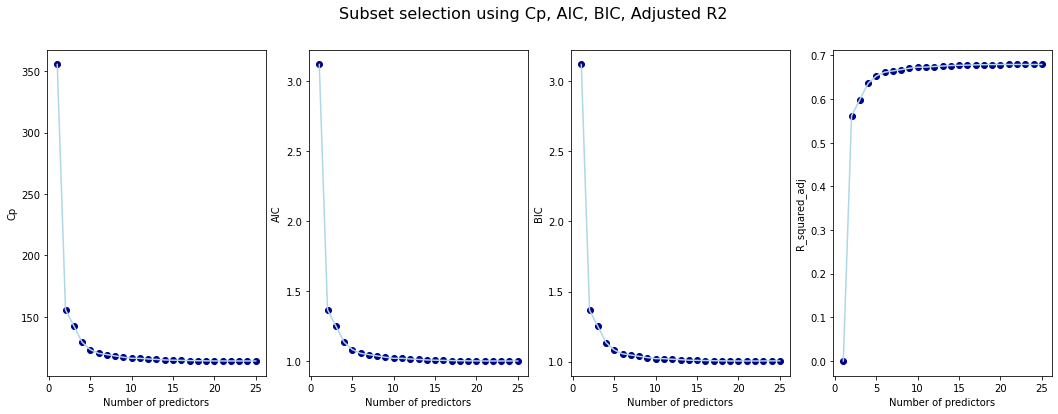

In [184]:
variables = ['Cp', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(models_bwd['n_features'],models_bwd[v], color = 'lightblue')
    ax.scatter(models_bwd['n_features'],models_bwd[v], color = 'darkblue')
    #if v == 'R_squared_adj':
    #    ax.plot(models_bwd[v].max(),models_bwd[v].max(), marker = 'x', markersize = 20)
    #else:
    #    ax.plot(models_bwd[v].min(),models_bwd[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using Cp, AIC, BIC, Adjusted R2', fontsize = 16)
plt.savefig('fig/' + 'Metrics_Subset_Selection.png', dpi=200)
plt.show()

Pese a que todos los estimadores coinciden en que el modelo es más preciso considerando todos los predictores, se observa que el test error no augmenta considerablemente hasta la decimozexta iteración (de 9 predictores). De hecho, desde la primera hasta la quinta iteración el test error en la mayoría de los estimadores estadísticos.

Se escoge como modelo base el correspondiente a la decimosexta iteración, que contiene los 9 mejores predictores. A continuación se muestran las variables escogidas para el modelo base:

In [185]:
best_features1=models_bwd['features'][10]
best_features1.remove('const')
best_features1

['Generacion_renovable_MW',
 'Demanda_real_MW',
 'Generacion_TG_MW',
 'Aportacion_renovable_%',
 'Temp_Rocio_ºC',
 'GHI_Wm2',
 'Zenith_º',
 'Weekday',
 'Season_i']

In [186]:
model = sm.OLS(train_y,train_X[best_features1])  #b Creamos regresión lineal
regr_OLS = model.fit() # fitting
regr_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Precio_generacion_€MWh   R-squared (uncentered):                   0.987
Model:                                OLS   Adj. R-squared (uncentered):              0.987
Method:                     Least Squares   F-statistic:                          3.237e+05
Date:                    Wed, 12 May 2021   Prob (F-statistic):                        0.00
Time:                            18:15:25   Log-Likelihood:                     -1.6791e+05
No. Observations:                   39391   AIC:                                  3.358e+05
Df Residuals:                       39382   BIC:                                  3.359e+05
Df Model:                               9                                                  
Covariance Type:                nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Generacion_renovable_MW    -0.4396      0.007    -59.942      0.000      -0.454      -0.425
Demanda_real_MW             0.1681      0.001    132.850      0.000       0.166       0.171
Generacion_TG_MW            0.0012      0.006      0.193      0.847      -0.011       0.013
Aportacion_renovable_%      0.8736      0.029     30.154      0.000       0.817       0.930
Temp_Rocio_ºC               2.6757      0.031     85.022      0.000       2.614       2.737
GHI_Wm2                     0.0365      0.001     69.479      0.000       0.035       0.038
Zenith_º                    0.4703      0.003    143.314      0.000       0.464       0.477
Weekday                     1.2575      0.043     29.044      0.000       1.173       1.342
Season_i                    4.1256      0.080     51.339      0.000       3.968       4.283
==============================================================================
Omnibus:                    18826.913   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           305194.620
Skew:                           1.897   Prob(JB):                         0.00
Kurtosis:                      16.098   Cond. No.                         509.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
# Evaluamos
print ('Train R2 score: ', metrics.r2_score(train_y,regr_OLS.predict(train_X[best_features1])))
print ('Test R2 score: ', metrics.r2_score(test_y,regr_OLS.predict(test_X[best_features1])))

Train R2 score:  0.16998639141964955
Test R2 score:  0.16759552658085275


Tras entrenar el algoritmo escogido OLS, se obtiene un R2 de 0,684 que será nuestro BENCHMARK.

In [188]:
model=LinearRegression()
regr_MLR=model.fit(train_X[best_features1], train_y)

print('Coef and Intercept: {} {}'.format(regr_MLR.coef_, regr_MLR.intercept_))
# Evaluamos
print('Training Score: {}'.format(regr_MLR.score(train_X[best_features1], train_y)))
print('Testing Score: {}'.format(regr_MLR.score(test_X[best_features1], test_y)))
# Compute MSE for training and testing sets 
print('Training MSE: {}'.format(np.mean((regr_MLR.predict(train_X[best_features1]) - train_y)**2)))
print('Testing MSE: {}'.format(np.mean((regr_MLR.predict(test_X[best_features1]) - test_y)**2)))
# Compute RMSE for training and testing sets 
print('Training RMSE: {}'.format(np.sqrt(np.mean((regr_MLR.predict(train_X[best_features1]) - train_y)**2))))
print('Testing RMSE: {}'.format(np.sqrt(np.mean((regr_MLR.predict(test_X[best_features1]) - test_y)**2))))
# Compute MAE for training and testing sets 
print('Training MAE: {}'.format(np.mean(np.absolute(regr_MLR.predict(train_X[best_features1]) - train_y))))
print('Testing MAE: {}'.format(np.mean(np.absolute(regr_MLR.predict(test_X[best_features1]) - test_y))))



Coef and Intercept: [[ 0.08742129 -0.09775154  0.2515721  -1.10558559  0.67346286 -0.01211324
  -0.0677923  -0.50285957  1.61793785]] [198.40659305]
Training Score: 0.6732505274983668
Testing Score: 0.6835776372368585
Training MSE: Precio_generacion_€MWh    116.155155
dtype: float64
Testing MSE: Precio_generacion_€MWh    109.269735
dtype: float64
Training RMSE: Precio_generacion_€MWh    10.77753
dtype: float64
Testing RMSE: Precio_generacion_€MWh    10.453216
dtype: float64
Training MAE: Precio_generacion_€MWh    6.033219
dtype: float64
Testing MAE: Precio_generacion_€MWh    6.008795
dtype: float64


Si utilizamos los mismos indicadores y entrenamos un algoritmo MLR de la librería Scikit-learn, se obtiene un R2 idéntico de 0,684. Esto nos indica que se ha realizado el proceso exitosamente. 

In [189]:
#Almacenamos los valores predichos por el modelo
y_OLS = regr_OLS.predict(test_X[best_features1])

## **5. Featuring selection**

Feature Selection es uno de los núcleos conceptuales en machine learning que presenta un gran impacto en el comportamiento de tu modelo. Los atributos de los datos que usas para entrenar tu modelo de machine learning tienen una enorme influencia en el rendimiento que puedes conseguir (Raheel Shaikh, Oct 18).

Las características irrelevantes o parcialmente relevantes pueden afectar negativamente en el comportamiento del modelo. El feature selection y el data cleaning son pasos clave en el proceso de diseño del modelo de aprendizaje.


¿Como seleccionar los atributos y cuales son los beneficios de llevar a cabo el feature selection antes de modelar tus datos?
- Reduce el Overfitting: Menos datos redundantes, menores posibilidades de tomar decisiones en base al ruido.
- Mejora la precisión: Menos datos engañosos, mejora la precisión del modelo.
- Reduce el tiempo de entrenamiento: Menos datos, reduce la complejidad algorítmica y los algoritmos entrenan más rápido.

### **4.1 Matriz de correlación**

En este apartado se analizan aquellos datos recogidos en tiempo real y la correlación que presentan con el precio de generación (target). 

Se lleva a cabo esta discriminación ya que los datos recogidos a tiempo real mediante sensores y los datos obtenidos en day-ahead a traves de modelos predictivos, serán utilizados para aplicaciones distintas.

#### Matriz de correlación

Para los real time features se decide utilizar el método de filtraje. Este método consiste en filtrar y quedarse únicamente con el subset de aributos más relevantes. El modelo es construido tras la selección de atributos. El filtrado se lleva cabo mediante una matriz de correlación.

En primer lugar se grafica un mapa de calor para observar la correlación de las variables independientes con la variable de salida 'Precio_generacion_€MWh'. Solamente seleccionaremos aquellos atributos que presenten una correlación superior a 0.3 (cogiendo el valor absoluto) con la variable de salida.

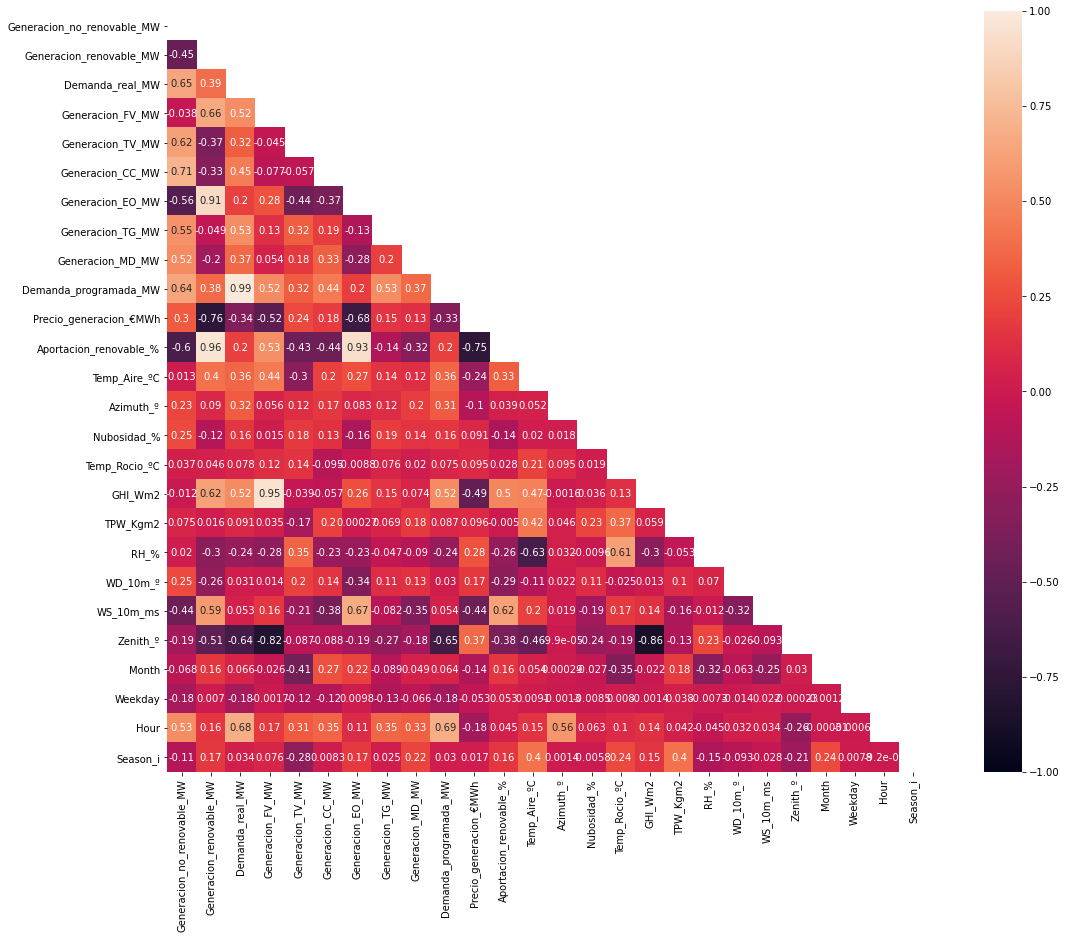

In [190]:
# Ploting the Electrical Real Time variables.
corrmat = df_ML.corr()
# Draw the heatmap using seaborn

# Quitar valores repetidos
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,14))
sns.heatmap(corrmat, vmin=-1, vmax=1, square=True, annot=True, mask=mask)

plt.savefig('fig/' + 'Pearson_Matrix_Heatmap.png', dpi=200, bbox_inches='tight')
plt.show()

In [191]:
#Correlación con la variable de salida
cor_target = abs(corrmat["Precio_generacion_€MWh"])

#Seleccionamos los atributos con mayor correlación
relevant_features = cor_target[cor_target>0.2]
relevant_features

Generacion_no_renovable_MW    0.304913
Generacion_renovable_MW       0.762788
Demanda_real_MW               0.338105
Generacion_FV_MW              0.518843
Generacion_TV_MW              0.241742
Generacion_EO_MW              0.681781
Demanda_programada_MW         0.333483
Precio_generacion_€MWh        1.000000
Aportacion_renovable_%        0.751612
Temp_Aire_ºC                  0.240379
GHI_Wm2                       0.485275
RH_%                          0.280922
WS_10m_ms                     0.438786
Zenith_º                      0.369676
Name: Precio_generacion_€MWh, dtype: float64

Como se puede ver, solo los atributos mostrados en pantalla son variables relevantes, de modo que eliminaremos todos los otros atributos para no confundir al modelo. Sin embargo, este no es el final de proceso. Una de las premisas de las regresiones lineales es que las variables independientes no deben estar correlacionadas entre sí, si lo están tendremos que quedarnos solo con una de ella y descartar las demás. 

In [192]:
indexes=[]

for i in range(0,len(df_ML.columns)):
    for j in range (0,len(relevant_features.index)):
        if relevant_features.index[j]==df_ML.columns[i]:
            indexes.append(i)

df_ML_f2 = pd.DataFrame(df_ML.iloc[:,indexes], columns=df_ML.columns[indexes])

# Función para ver solo una mitad de la matriz
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Function to get top correlations 
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_ML_f2, 10))

Top Absolute Correlations
Demanda_real_MW          Demanda_programada_MW     0.986558
Generacion_renovable_MW  Aportacion_renovable_%    0.964014
Generacion_FV_MW         GHI_Wm2                   0.951922
Generacion_EO_MW         Aportacion_renovable_%    0.929803
Generacion_renovable_MW  Generacion_EO_MW          0.906539
GHI_Wm2                  Zenith_º                  0.862484
Generacion_FV_MW         Zenith_º                  0.817254
Generacion_renovable_MW  Precio_generacion_€MWh    0.762788
Precio_generacion_€MWh   Aportacion_renovable_%    0.751612
Generacion_EO_MW         Precio_generacion_€MWh    0.681781
dtype: float64


Se decide eliminar 'Demanda_programada_MW', 'Aportacion_renovable_%', 'GHI_Wm2' pues estos atributos están fuertemente relacionados entre sí y entre otros atributos como la generación renovable, demanda real o generación fotovoltaica.

In [193]:
df_ML_f2=df_ML_f2.drop(['Demanda_programada_MW','Aportacion_renovable_%','GHI_Wm2'],axis=1)
best_features2=df_ML_f2.columns.tolist()
best_features2.remove('Precio_generacion_€MWh')

df_ML_f2

,Generacion_no_renovable_MW,Generacion_renovable_MW,Demanda_real_MW,Generacion_FV_MW,Generacion_TV_MW,Generacion_EO_MW,Precio_generacion_€MWh,Temp_Aire_ºC,RH_%,WS_10m_ms,Zenith_º
2019-01-01 00:00:00,347.6,0.0,347.6,0.0,173.2,0.0,156.18,16.7,54.6,3.5,163.0
2019-01-01 00:10:00,345.0,0.0,345.0,0.0,176.2,0.0,156.18,16.7,54.4,3.5,165.0
2019-01-01 00:20:00,346.9,0.1,347.0,0.0,174.9,0.1,156.18,16.8,54.8,3.5,167.0
2019-01-01 00:30:00,344.5,0.2,344.7,0.0,173.8,0.2,156.18,17.0,55.4,3.6,169.0
2019-01-01 00:40:00,342.9,0.1,343.0,0.0,175.8,0.1,156.18,17.1,55.9,3.6,171.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:10:00,371.4,2.3,373.7,0.0,95.4,2.3,140.89,14.0,53.8,2.9,152.0
2019-12-31 23:20:00,368.0,2.4,370.4,0.0,85.5,2.4,140.89,13.9,52.7,2.9,154.0
2019-12-31 23:30:00,362.6,2.7,365.3,0.0,79.9,2.7,140.89,13.9,51.5,3.0,156.0
2019-12-31 23:40:00,355.2,5.0,360.2,0.0,75.9,5.0,140.89,13.9,50.3,3.0,159.0


Finalmente nos quedamos con los siguientes atributos:

- Generacion_no_renovable_MW
- Generacion_renovable_MW
- Demanda_real_MW
- Generacion_FV_MW
- Generacion_TV_MW
- Generacion_EO_MW
- Temp_Aire_ºC
- RH_%
- WS_10m_ms
- Zenith_º




### **4.2 Feature importance**

En este apartado se analizan aquellos datos recogidos en day-ahead (día previo) y la correlación que presentan con el precio de generación (target). 

Se lleva a cabo esta discriminación ya que los datos recogidos a tiempo real mediante sensores y los datos obtenidos en day-ahead a traves de modelos predictivos, serán utilizados para aplicaciones distintas.

#### Feature importance

En este caso se decide utilizar la propiedad 'feature importance' del modelo para seleccionar aquellos atributos que son más importantes para la variable de salida (target).

Este método da una puntuación a cada atributo del dataset, cuanto mayor es la puntuación, mayor es la relevancia de esa variable independiente frente a la variable de salida (target).


[0.01058048 0.26897843 0.01226011 0.03175843 0.0165264  0.01599311
 0.10353219 0.02914812 0.01266796 0.02738782 0.20204579 0.01566749
 0.01461169 0.00664061 0.02070468 0.01186542 0.01634272 0.01420261
 0.01440379 0.01597101 0.01504902 0.04206037 0.01412417 0.03555957
 0.03191804]


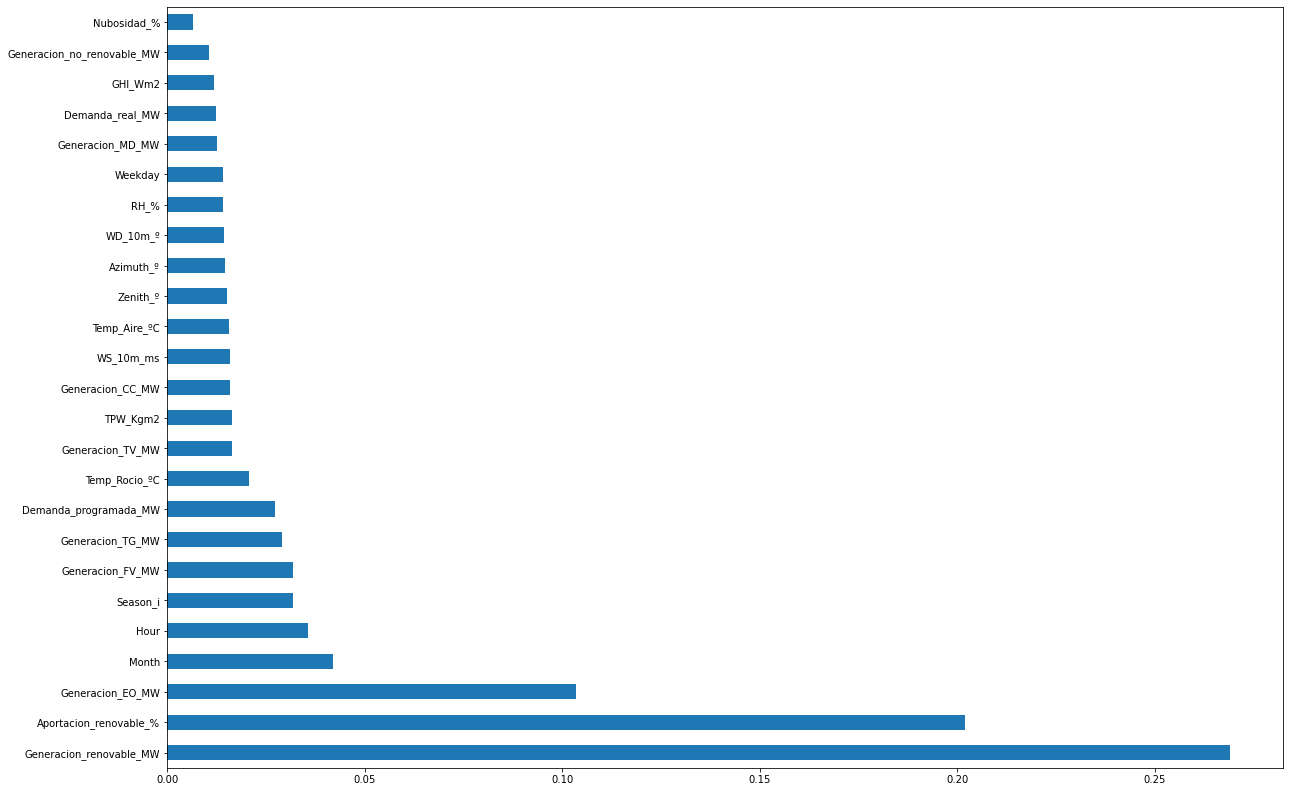

In [194]:
import pandas as pd
import numpy as np
X = df_ML.drop(['Precio_generacion_€MWh'],axis=1)  #independent columns
y = df_ML.iloc[:,10]    #target column i.e price generation
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
plt.figure(figsize=(20,14))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')


plt.savefig('fig/' + 'Feature_Importance_Property.png', dpi=200, bbox_inches='tight')
plt.show()

Las variables que se destacan del resto en cuanto a relevancia son las de la generación renovable, aportación renovables y generación eólica como era de esperar. Nos quedamos con los 9 atributos más relevantes:

- Generacion_renovable_MW
- Aportacion_renovable_%
- Generacion_EO_MW
- Month
- Hour
- Season_i
- Generacion_TG_MW
- Demanda_programada_MW
- Generacion_FV_MW

In [195]:
df_ML_f3=df_ML.drop(['Temp_Rocio_ºC','GHI_Wm2','TPW_Kgm2','Generacion_TV_MW','Generacion_CC_MW','Temp_Aire_ºC','WS_10m_ms','Zenith_º','RH_%','WD_10m_º','Weekday','Azimuth_º','Generacion_MD_MW','Demanda_real_MW','Generacion_no_renovable_MW','Nubosidad_%'],axis=1)
best_features3=df_ML_f3.columns.tolist()
best_features3.remove('Precio_generacion_€MWh')
df_ML_f3

,Generacion_renovable_MW,Generacion_FV_MW,Generacion_EO_MW,Generacion_TG_MW,Demanda_programada_MW,Precio_generacion_€MWh,Aportacion_renovable_%,Month,Hour,Season_i
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,343.4,156.18,0.000000,1,0,0
2019-01-01 00:10:00,0.0,0.0,0.0,0.0,343.4,156.18,0.000000,1,0,0
2019-01-01 00:20:00,0.1,0.0,0.1,0.0,343.4,156.18,0.028818,1,0,0
2019-01-01 00:30:00,0.2,0.0,0.2,0.0,343.4,156.18,0.058021,1,0,0
2019-01-01 00:40:00,0.1,0.0,0.1,0.0,343.4,156.18,0.029155,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:10:00,2.3,0.0,2.3,0.0,370.1,140.89,0.615467,12,23,0
2019-12-31 23:20:00,2.4,0.0,2.4,0.0,370.1,140.89,0.647948,12,23,0
2019-12-31 23:30:00,2.7,0.0,2.7,0.0,370.1,140.89,0.739119,12,23,0
2019-12-31 23:40:00,5.0,0.0,5.0,0.0,370.1,140.89,1.388118,12,23,0


## **6. Other Regression Models**

En este apartado se van a probar otros modelos de regresión que suelen ser más efectivos en modelos no lineales de alta complejidad. 

Para realizar la comparación de estos modelos con el modelo base de regresión lineal, se va a utilizar el subset determinado en el stepwise backward elimination. Se descarta entrenar los algoritmos con el dataset origen para reducir el tiempo computacional y para que la comparación con el modelo base sea partiendo de la premisa que todos los modelos han sido entrenados con la misma cantidad de información. 

Si los resultados no son los esperados, siempre se puede manipular el dataset, añadir algunos datos o volver al dataset origen para entrenar de nuevo los modelos.

Probaremos los siguientes modelos:

    1.Support vector regression 

    2.KNeighborsRegressor

    3.Random Forest Regressor

    4.Gradient Boosting Regressor

    5.ExtraTrees Regressor

    6.Multi Layer Preceptron Regressor


### **6.1 Real Time Features**

In [196]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


In [197]:
# 75% de datos para entrenar, 25% para testear
train, test = train_test_split(df_ML,test_size=0.25,random_state=40)

train.describe()

,Generacion_no_renovable_MW,Generacion_renovable_MW,Demanda_real_MW,Generacion_FV_MW,Generacion_TV_MW,Generacion_CC_MW,Generacion_EO_MW,Generacion_TG_MW,Generacion_MD_MW,Demanda_programada_MW,...,GHI_Wm2,TPW_Kgm2,RH_%,WD_10m_º,WS_10m_ms,Zenith_º,Month,Weekday,Hour,Season_i
count,39391.000000,39391.00000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,...,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000,39391.000000
mean,330.440258,78.85437,409.294623,21.748719,123.520858,173.622909,57.105651,11.907301,21.389193,409.774969,...,245.086136,16.115252,69.648158,68.509609,5.925412,89.653119,6.525958,3.990074,11.508365,1.504557
std,82.041858,68.05495,79.122707,29.930521,45.379873,52.689178,53.372587,17.555855,13.826444,78.759070,...,323.935720,4.939292,13.017300,81.177426,2.538415,41.763020,3.443768,1.996272,6.915419,1.127974
min,91.000000,0.00000,179.600000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,262.900000,...,0.000000,4.700000,21.300000,0.000000,0.000000,5.000000,1.000000,1.000000,0.000000,0.000000
25%,273.200000,16.70000,329.000000,0.000000,93.000000,143.500000,6.500000,0.000000,14.700000,330.600000,...,0.000000,12.900000,63.100000,30.000000,4.200000,54.000000,4.000000,2.000000,6.000000,0.000000
50%,324.400000,64.80000,431.500000,0.000000,122.700000,163.200000,41.400000,0.000000,18.800000,432.700000,...,6.000000,15.600000,72.400000,41.000000,6.100000,90.000000,7.000000,4.000000,12.000000,2.000000
75%,393.500000,128.20000,477.100000,43.800000,162.000000,202.000000,102.200000,20.700000,34.900000,478.300000,...,485.000000,18.400000,79.100000,57.000000,7.700000,125.000000,10.000000,6.000000,18.000000,3.000000
max,550.900000,265.60000,570.700000,99.800000,211.700000,394.300000,181.900000,200.700000,40.600000,570.900000,...,1090.000000,40.500000,95.600000,360.000000,14.300000,175.000000,12.000000,7.000000,23.000000,3.000000


In [198]:
# Podemos ver las features y la columna target
feature_vars = train.drop(['Precio_generacion_€MWh'],axis=1)
target_vars = train[['Precio_generacion_€MWh']]

#Split training dataset 
#train_X = train[feature_vars.columns]
train_X = train[best_features1] #[['Month','Weekday','Hour','Season_i','Generacion_no_renovable_MW','Generacion_renovable',Demanda_real_MW']]
train_y = train[target_vars.columns] #['Precio_generacion_€MWh']

#Split test dataset
#test_X = test[feature_vars.columns]
test_X = test[best_features1] #[['Month','Weekday','Hour','Season_i','Generacion_no_renovable_MW','Generacion_renovable',Demanda_real_MW']]
test_y = test[target_vars.columns] #['Precio_generacion_€MWh']

print('Train and test sizes {} {}'.format(train_X.shape, test_X.shape))

Train and test sizes (39391, 9) (13131, 9)


El primer paso es la estandarización y normalización de las variables. Algunos modelos no trabajan bien si las variables no están escaladas.

In [199]:
#Escalado de variables. Algunos modelos no trabajan bien si las variables no están escaladas.
scalerX = StandardScaler().fit(train_X) #

#train_y2 = np.expand_dims(train_y, axis=1) # Expand the shape of the array from (253,) to (253, 1).
scalery = StandardScaler().fit(train_y) # Create the transformer StandardScaler and perform the fitting for the target

print("\nBefore transformation:")
print('Training: Max {}, min {}, mean {}, and var {}'.format(np.max(train_y.iloc[:,0]), np.min(train_y.iloc[:,0]), np.mean(train_y.iloc[:,0]), np.var(train_y.iloc[:,0])))
print('Testing: Max {}, min {}, mean {}, and var {}'.format(np.max(test_y.iloc[:,0]), np.min(test_y.iloc[:,0]), np.mean(test_y.iloc[:,0]), np.var(test_y.iloc[:,0])))


# Normalization of train and test data using mean and variance of the training:
train_X = scalerX.transform(train_X)
train_y = scalery.transform(train_y)
test_X = scalerX.transform(test_X)
#test_y2 = np.expand_dims(test_y, axis=1)
test_y = scalery.transform(test_y)

print("\nAfter transformation:")
print('Training: Max {}, min {}, mean {}, and var {}'.format(np.max(train_y), np.min(train_y), np.mean(train_y), np.var(train_y)))
print('Testing: Max {}, min {}, mean {}, and var {}'.format(np.max(test_y), np.min(test_y), np.mean(test_y), np.var(test_y)))


Before transformation:
Training: Max 370.48, min 92.19, mean 147.5440943362685, and var 355.48689289597314
Testing: Max 292.71, min 92.19, mean 147.83442997486875, and var 345.32873602987905

After transformation:
Training: Max 11.824103553354766, min -2.9358776532007727, mean 6.448656496007611e-16, and var 1.0
Testing: Max 7.699328180780024, min -2.9358776532007727, mean 0.015398859352882304, and var 0.9714246655246744


In [200]:
# Lista de modelos a probar
models = [
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingClassifier: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] ,
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]


In [201]:
# Correr los modelos
import time
from math import sqrt
from sklearn.metrics import mean_squared_error

model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(train_X,train_y)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2"] = metrics.r2_score(train_y,curr_model.predict(train_X))
    curr_model_data["Test_R2"] = metrics.r2_score(test_y,curr_model.predict(test_X))
    curr_model_data['Test_R2_adj'] = 1-((len(test_y)-1)/(len(test_y)-len(best_features1)-1)*(1-curr_model_data["Test_R2"]))
    curr_model_data["Test_MSE_€MWh"] = mean_squared_error(scalery.inverse_transform(test_y),scalery.inverse_transform(curr_model.predict(test_X)))
    curr_model_data["Test_RMSE_€MWh"] = sqrt(mean_squared_error(scalery.inverse_transform(test_y),scalery.inverse_transform(curr_model.predict(test_X))))
    curr_model_data["Test_MAE_€MWh"] = metrics.mean_absolute_error(scalery.inverse_transform(test_y),scalery.inverse_transform(curr_model.predict(test_X)))
    model_data.append(curr_model_data)

C:\Users\Mini\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-201-53a97aa9fed3>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  curr_model.fit(train_X,train_y)
<ipython-input-201-53a97aa9fed3>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  curr_model.fit(train_X,train_y)
C:\Users\Mini\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Mini\anaconda3\lib\site-packages\skle

In [202]:
# Pasar a datframe
df_model = pd.DataFrame(model_data)
df_model

,Name,Train_Time,Train_R2,Test_R2,Test_R2_adj,Test_MSE_€MWh,Test_RMSE_€MWh,Test_MAE_€MWh
0,KNeighborsRegressor:,0.824133,0.927666,0.876361,0.876276,42.696242,6.534236,3.063628
1,SVR:,55.332025,0.715511,0.725576,0.725388,94.766469,9.734807,4.705580
2,RandomForest,24.914954,0.975779,0.835328,0.835215,56.865883,7.540947,3.645712
3,ExtraTreeRegressor :,12.804103,1.000000,0.879672,0.879589,41.552785,6.446145,3.059308
4,GradientBoostingClassifier:,6.758210,0.723023,0.720419,0.720227,96.547333,9.825850,5.370996
5,XGBRegressor:,2.500033,0.874192,0.783482,0.783333,74.769942,8.646961,4.801115
6,MLPRegressor:,19.410878,0.731072,0.732711,0.732528,92.302446,9.607416,5.395958


Como se puede observar, todas las métricas de evaluación apuntan a que los mejores modelos son el KNR y el ETR. Aún así hay otro modelo que les sigue de cerca (RandomForest). TENER EN CUENTA QUE EL MSE,RMSE,MAE son errores absolutos y tienen unidad (€/MWh)

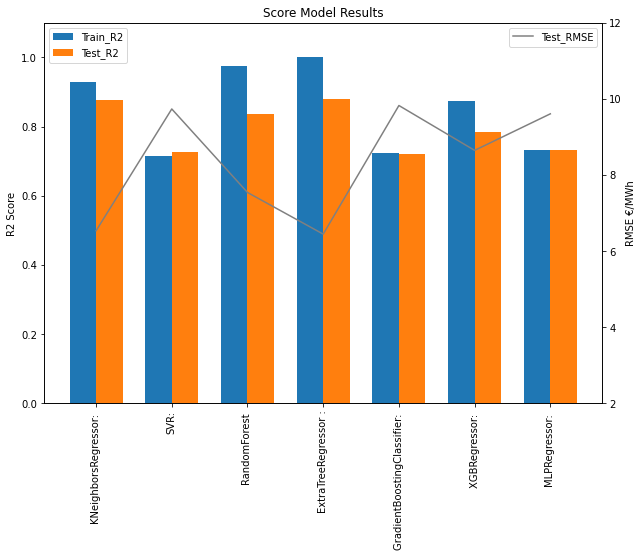

In [203]:
fig, ax1 = plt.subplots(figsize=(10, 7))

x = np.arange(len(df_model['Name']))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax1.bar(x - width/2, df_model['Train_R2'], width, label='Train_R2')
rects2 = ax1.bar(x + width/2, df_model['Test_R2'], width, label='Test_R2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylim(0,1.1)
ax1.set_ylabel('R2 Score')
ax1.set_title('Score Model Results')
ax1.set_xticks(x)
ax1.set_xticklabels(df_model['Name'])
ax1.legend(loc='upper left')
plt.xticks(rotation=90)

#ax1.bar(rects1, padding=3)
#ax1.bar(rects2, padding=3)

ax2=ax1.twinx() # instantiate a second axes that shares the same x-axis

ax2.set_ylim(2,12)
ax2.set_ylabel('RMSE €/MWh')
ax2.plot(df_model['Name'],df_model['Test_RMSE_€MWh'], color='gray',label='Test_RMSE')
ax2.legend(loc='upper right')

plt.savefig('fig/' + 'Score_Model_Results.png', dpi=200, bbox_inches='tight')
plt.show()

#### Obervaciones

1. Mejores modelos ETR y KNR con Test R2 score de 0.879 y 0.876 respectivamente 
2. Menor RMSE score también ETR y KNR con 0.579 y 0.573 respectivamente
3. SVR y GBC los peores!
4. Extra Tree Regressor tiene un training R2 score 1.0 (overfitting?)
5. KNeighbors Regressor tiene tiempo de entreno de 0.825

Se escoge el algortimo KNR para la construcción de nuestro modelo. Presenta un coeficiente de determinación muy bueno con un tiempo de computación muy bajo.

Para la elección del modelo definitivo se comparan diferentes métodos de featuring selection:

- Stepwise Backward Selection
- Feature importance ETR property
- Pearson matrix filtering method


In [204]:
# 75% de datos para entrenar, 25% para testear
train, test = train_test_split(df_ML,test_size=0.25,random_state=40)

In [205]:
# Podemos ver las features y la columna target
target_vars = train[['Precio_generacion_€MWh']]

#Split training dataset 
train_X1 = train[best_features1]
train_X2 = train[best_features2] 
train_X3 = train[best_features3]
#train_X4 = train[best_features4]
train_y = train[target_vars.columns] #['Precio_generacion_€MWh']

#Split test dataset
#test_X = test[feature_vars.columns]
test_X1 = test[best_features1]
test_X2 = test[best_features2]
test_X3 = test[best_features3]
#test_X4 = test[best_features4]
test_y = test[target_vars.columns] #['Precio_generacion_€MWh']


#Escalado de variables. Algunos modelos no trabajan bien si las variables no están escaladas.
scalerX1 = StandardScaler().fit(train_X1) #
scalerX2 = StandardScaler().fit(train_X2)
scalerX3 = StandardScaler().fit(train_X3)
#scalerX4 = StandardScaler().fit(train_X4)
scalery = StandardScaler().fit(train_y) # Create the transformer StandardScaler and perform the fitting for the target

# Normalization of train and test data using mean and variance of the training:
train_X1 = scalerX1.transform(train_X1)
train_X2 = scalerX2.transform(train_X2)
train_X3 = scalerX3.transform(train_X3)
#train_X4 = scalerX4.transform(train_X4)
train_y = scalery.transform(train_y)
test_X1 = scalerX1.transform(test_X1)
test_X2 = scalerX2.transform(test_X2)
test_X3 = scalerX3.transform(test_X3)
#test_X4 = scalerX4.transform(test_X4)
test_y = scalery.transform(test_y)



In [206]:
from sklearn.metrics import mean_squared_error

reg1_KNR = neighbors.KNeighborsRegressor(algorithm='auto', n_neighbors=198, weights='distance')
reg2_KNR = neighbors.KNeighborsRegressor(algorithm='auto', n_neighbors=198, weights='distance')
reg3_KNR = neighbors.KNeighborsRegressor(algorithm='auto', n_neighbors=198, weights='distance')
#reg4_KNR = neighbors.KNeighborsRegressor(algorithm='auto', n_neighbors=198, weights='distance')

reg1_KNR.fit(train_X1,train_y)
reg2_KNR.fit(train_X2,train_y)
reg3_KNR.fit(train_X3,train_y)
#reg4_KNR.fit(train_X4,train_y)

models_KNR = pd.DataFrame(columns=["Featuring Selection", "n_features", "Train_R2", "Test_R2", "Test_RSME_€MWh", "Test_MAE_€MWh"], index = range(3))

models_KNR.iloc[0]=('Stepwise Backward Elimination', len(best_features1), reg1_KNR.score(train_X1,train_y), reg1_KNR.score(test_X1,test_y), np.sqrt(mean_squared_error(scalery.inverse_transform(test_y),scalery.inverse_transform(reg1_KNR.predict(test_X1)))),metrics.mean_absolute_error(scalery.inverse_transform(test_y),scalery.inverse_transform(reg1_KNR.predict(test_X1))))
models_KNR.iloc[1]=('Pearson Matrix Filtering', len(best_features2), reg2_KNR.score(train_X2,train_y), reg2_KNR.score(test_X2,test_y), np.sqrt(mean_squared_error(scalery.inverse_transform(test_y),scalery.inverse_transform(reg2_KNR.predict(test_X2)))),metrics.mean_absolute_error(scalery.inverse_transform(test_y),scalery.inverse_transform(reg2_KNR.predict(test_X2))))
models_KNR.iloc[2]=('Feature importance', len(best_features3),reg3_KNR.score(train_X3,train_y),reg3_KNR.score(test_X3,test_y),np.sqrt(mean_squared_error(scalery.inverse_transform(test_y),scalery.inverse_transform(reg3_KNR.predict(test_X3)))),metrics.mean_absolute_error(scalery.inverse_transform(test_y),scalery.inverse_transform(reg3_KNR.predict(test_X3))))                                                                                                                                                  
#models_KNR.iloc[3]=('Lasso regularitzation', len(best_features4),reg4_KNR.score(train_X4,train_y),reg4_KNR.score(test_X4,test_y),np.sqrt(mean_squared_error(scalery.inverse_transform(test_y),scalery.inverse_transform(reg4_KNR.predict(test_X4)))),metrics.mean_absolute_error(scalery.inverse_transform(test_y),scalery.inverse_transform(reg4_KNR.predict(test_X4))))                                                       

models_KNR

,Featuring Selection,n_features,Train_R2,Test_R2,Test_RSME_€MWh,Test_MAE_€MWh
0,Stepwise Backward Elimination,9,1,0.746281,9.36037,5.10271
1,Pearson Matrix Filtering,10,1,0.726999,9.70954,5.38249
2,Feature importance,9,1,0.765182,9.00497,4.65339


In [207]:
# Guardamos el archivo en formato CSV y Pickle
import pickle

def save_obj(obj, name ):
       with open('obj/'+ name + '.pkl', 'wb') as f:
           pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_obj(reg3_KNR, 'KNR_Model')
save_obj(scalerX3, 'scalerX')
save_obj(scalery, 'scalery')

No se consiguen notables mejoras con estos algoritmos, sin embargo, si no se hace el resample horario en el dataset y se considera el dataser con granularidad 10 minutal, los resultados son mucho mejores.... Hablarlo con Íngrid. 

Conseguimos resultados cercanos o superiores a R2=0,9 en el test set.
Después de tunear los hiperparámetros de KNN Regressor conseguimos un resultado de 0,9208.

Debatir también el punto de considerar todos los atributos o solo RT/DA features.

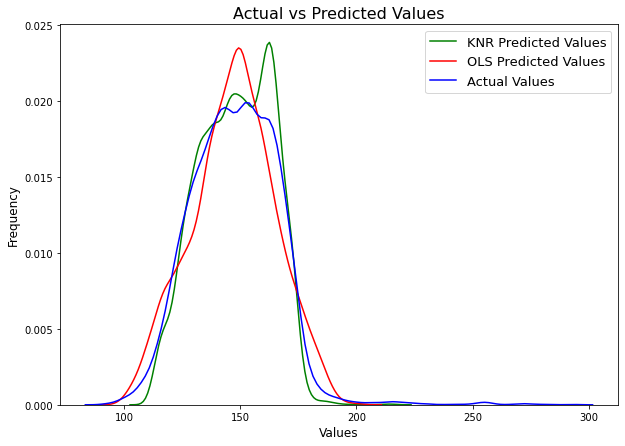

In [163]:
y_KNR = scalery.inverse_transform(reg3_KNR.predict(test_X3))
y_real = scalery.inverse_transform(test_y)

#Graficamos los valores predichos VS los valores reales
plt.figure(figsize=(10,7))
sns.distplot(y_KNR, hist = False, color = 'g', label = 'KNR Predicted Values')
sns.distplot(y_OLS, hist = False, color = 'r', label = 'OLS Predicted Values')
sns.distplot(y_real, hist = False, color = 'b', label = 'Actual Values')

plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'best', fontsize = 13)

plt.savefig('fig/' + 'Predicted_VS_Actual_MLR.png', dpi=200)

Como se puede observar, al graficar la distribución de datos de los valores predichos frente a los valores reales se detecta una desviación importante. Mediante la comparación de otros modelos más complejos, la aplicación del featuring selection, normalización, estandarización o la configuración de los hiperparámetros de los modelos se puede reducir el error y mejorar el índice de acierto.